In [1]:
import importlib
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import nue as nue
importlib.reload(nue)

<module 'nue' from '/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/nue.py'>

# notes

we're using cheat pandora! 

In [96]:
# keys = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/cheat_studies/intrnue_cheat_caf.root:recTree").keys()

# for key in keys:
#     if "charge" in key:
#         print(key)

In [2]:
# nue_file = "/sbnd/data/users/lynnt/v09_75_03_02/data_caf_cheat.df"
nue_file = "/sbnd/data/users/lynnt/v09_75_03_02/cheat_studies/intrnue_cheat_caf_data.df"
nue_hdr_df_0 = pd.read_hdf(nue_file,key="hdr")
nue_nuu_df_0 = pd.read_hdf(nue_file,key="mcnu")
nue_nuprim_df_0 = pd.read_hdf(nue_file,key="mcnuprim")
nue_slctrk_df_0 = pd.read_hdf(nue_file,key="slctrk")
nue_slcshw_df_0 = pd.read_hdf(nue_file,key="slcshw")

nu_idx_set = ["ntuple","entry","nu_index"]
slc_idx_set = ["ntuple","entry","rec.slc__index"]

nue_hdr_df = nue.flatten_df(nue_hdr_df_0)[["ntuple","entry","rec_hdr_run","rec_hdr_subrun","rec_hdr_evt","rec_hdr_pot"]].rename(columns={"rec_hdr_subrun":"subrun","rec_hdr_run":"run","rec_hdr_evt":"event"})
nue_sub_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/cheat_studies/intrnue_cheat_opt0_exitFalse.root:opt0finder/flash_match_tree").arrays(['run','subrun','event'],library="pd").drop_duplicates()
nue_sub_df = nue_hdr_df.merge(nue_sub_opt0_df,on=["run","subrun",'event'],how="inner")

In [3]:
# make nue dataframes
nue_nuprim_df = nue_nuprim_df_0.copy()

whereFV = nue.maskTrueVtxFv(nue_nuprim_df)
whereSig = ((nue_nuprim_df.iscc==1) & (abs(nue_nuprim_df.pdg)==12) & (abs(nue_nuprim_df.prim.pdg)==11))# & (nue_nuprim_df.prim.startE > 0.2) )
nue_nuprim_df = nue.defineBackground(nue_nuprim_df)
nue_nuprim_df["signal"] = np.where(whereFV & whereSig,0,nue_nuprim_df["signal"])

nue_nu_df = nue_nuprim_df.loc[:,:,:,0]
nue_nu_df = nue.flatten_df(nue_nu_df)
nue_nu_df["nu_index"] = nue_nu_df["rec.mc.nu__index"]

# get the dataframe that contains the counts of each PDG per event 
nue_pdg_counts = nue.getPDGCounts(nue_nuprim_df)

# merge the pdg counts into the full nue_nu_df 
nue_nu_df = nue_nu_df.merge(nue_pdg_counts,how="left",on=["ntuple","entry","rec.mc.nu__index"])

# get slcpfp dataframe 
slcpfp_nue_df = nue.getPFP(nue_slcshw_df_0,nue_slctrk_df_0,cheat=True)

# merge slcpfp with neutrino events 
slcpfp_nue_nu_df = slcpfp_nue_df.merge(nue_nu_df,on=nu_idx_set,how="left")
slcpfp_nue_nu_df["signal"] = np.where(slcpfp_nue_df.slc_tmatch_idx==-999,5,slcpfp_nue_nu_df['signal'])

# perform (reco) containment cut
# slcpfp_nue_nu_df = nue.cutContainment(slcpfp_nue_nu_df)

for this sample, intrnue + cosmics, we can break-down the components of our events into: 
- 1eNp0pi FV (signal)
- numuCC FV
- nue NC, FV 
- other nueCC, FV 
- dirt (outside FV)

In [4]:
nue_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/cheat_studies/intrnue_cheat_opt0_exitFalse.root:opt0finder/flash_match_tree").arrays(['run','subrun','event','tpc','pfpid','score','hypo_pe','flash_pe'],library="pd")
nue_opt0_df["frac_pe"] = (nue_opt0_df.hypo_pe*0.90 - nue_opt0_df.flash_pe)/nue_opt0_df.flash_pe
nue_opt0_df = nue_opt0_df[nue_opt0_df.pfpid != -1]

# for multiple matches per slice, take the match with the best score
nue_opt0_df = nue_opt0_df[(nue_opt0_df.score == nue_opt0_df.groupby(["run","subrun","event","pfpid"])["score"].transform(max))]
nue_hdr_opt0_df = nue_sub_df[["ntuple","entry","run","subrun","event"]].drop_duplicates().merge(nue_opt0_df,how="left",on=["run","subrun","event"])
slcpfp_nue_nu_df = slcpfp_nue_nu_df.merge(nue_hdr_opt0_df.rename(columns={"pfpid":"slc_self"}),on=["ntuple","entry","slc_self"],how="left")

In [5]:
slc_opt0_nu_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx != -999 & run>0 & (signal < 3)")
slc_opt0_nu_df

,ntuple,entry,rec.slc__index,rec.slc.reco.pfp__index,slc_is_clear_cosmic,slc_vertex_x,slc_vertex_y,slc_vertex_z,slc_self,slc_tmatch_eff,...,prim_exit_count,prim_cont,run,subrun,event,tpc,score,hypo_pe,flash_pe,frac_pe
40,0,1,17,0,0,-170.464355,-175.781342,388.090851,22,0.931637,...,0.0,True,1.0,1.0,2.0,0.0,12969.410781,66433.059748,69353.594350,-0.137900
63,0,2,17,0,0,154.047928,67.506744,135.486328,21,0.898594,...,0.0,True,1.0,1.0,3.0,1.0,7347.596842,91570.304100,76227.619300,0.081147
88,0,3,20,0,0,-57.768047,15.962604,201.434235,27,0.864051,...,0.0,True,1.0,1.0,4.0,0.0,17710.216441,248287.242934,213636.526475,0.045975
122,0,5,12,0,0,18.016317,48.712635,263.876343,16,0.928762,...,0.0,True,1.0,1.0,6.0,1.0,40175.921774,78852.438709,79043.006775,-0.102170
160,0,7,10,0,0,-46.062668,-88.306549,398.552124,13,0.886204,...,0.0,True,1.0,1.0,8.0,0.0,1845.647411,51432.284981,43534.396500,0.063275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197066,0,9984,14,0,0,121.027756,122.484444,32.199406,18,0.918149,...,0.0,True,1.0,227.0,5.0,1.0,13053.108192,140919.797093,106033.909575,0.196106
197102,0,9986,9,0,0,-84.484131,-111.597130,412.401337,11,0.957104,...,1.0,False,1.0,227.0,7.0,0.0,20139.993090,29679.305693,34573.981425,-0.227414
197117,0,9987,12,0,0,-84.320297,-111.289963,374.891174,15,0.943784,...,0.0,True,1.0,227.0,8.0,0.0,36340.756469,92589.137568,74880.232650,0.112847
197134,0,9988,13,0,0,-176.349792,-144.866394,415.562927,17,0.947090,...,2.0,False,1.0,227.0,9.0,0.0,6006.762717,46391.918682,38210.341650,0.092707


In [6]:
slc_opt0_co_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx == -999 & run>0" )
slc_opt0_co_df

,ntuple,entry,rec.slc__index,rec.slc.reco.pfp__index,slc_is_clear_cosmic,slc_vertex_x,slc_vertex_y,slc_vertex_z,slc_self,slc_tmatch_eff,...,prim_exit_count,prim_cont,run,subrun,event,tpc,score,hypo_pe,flash_pe,frac_pe
0,0,0,0,0,0,-1585.886963,1850.000000,6057.050781,0,NaN,...,NaN,NaN,1.0,1.0,1.0,0.0,3.025154,95120.749194,709.980050,119.578986
1,0,0,1,0,0,-192.314590,1850.001465,787.807434,1,NaN,...,NaN,NaN,1.0,1.0,1.0,0.0,32.731355,17761.733796,709.980050,21.515506
2,0,0,2,0,0,284.418457,1850.000000,2317.004150,2,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,31.140902,37073.256851,76623.102525,-0.564545
3,0,0,3,0,0,996.534546,1850.654053,-57.256874,3,NaN,...,NaN,NaN,1.0,1.0,1.0,0.0,2.315549,50182.741640,709.980050,62.613713
4,0,0,4,0,0,180.151398,126.588707,405.557770,5,NaN,...,NaN,NaN,1.0,1.0,1.0,0.0,309.187254,14547.103807,709.980050,17.440509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197159,0,9990,3,0,0,-994.216003,1850.000000,1627.750366,4,NaN,...,NaN,NaN,1.0,227.0,11.0,0.0,1311.495642,52299.434430,184693.143800,-0.745148
197160,0,9990,4,0,0,-617.585144,1850.654053,1735.315308,5,NaN,...,NaN,NaN,1.0,227.0,11.0,0.0,376.532398,35657.169584,184693.143800,-0.826244
197161,0,9990,5,0,0,-516.317078,1850.000000,526.459717,7,NaN,...,NaN,NaN,1.0,227.0,11.0,1.0,23.002509,5638.666387,683.937425,6.419977
197162,0,9990,6,0,0,2196.357666,1850.654053,-2075.634277,8,NaN,...,NaN,NaN,1.0,227.0,11.0,0.0,1.034556,138077.345224,184693.143800,-0.327156


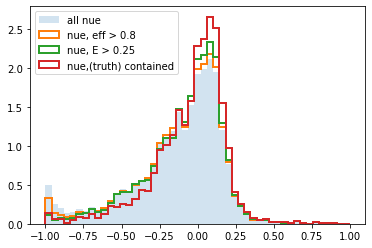

In [7]:
bins = np.linspace(-1,1,50)
this_nu = slc_opt0_nu_df.query("slc_tmatch_eff > 0.8").copy()
this_co = slc_opt0_co_df.copy()
plt.hist(slc_opt0_nu_df.frac_pe,
         bins=bins,alpha=0.20,          density=True,label="all nue")
plt.hist(this_nu.frac_pe,
         bins=bins,histtype="step",lw=2,density=True,label="nue, eff > 0.8")
plt.hist(this_nu.query("total_prim_depE > 0.25").frac_pe,
         bins=bins,histtype="step",lw=2,density=True,label="nue, E > 0.25")
plt.hist(this_nu.query("prim_cont == True").frac_pe,
         bins=bins,histtype="step",lw=2,density=True,label="nue,(truth) contained")
# plt.hist(this_nu.query("abs(position_x) < 100").frac_pe,
#          bins=bins,histtype="step",lw=2,density=True,label="nu, x < 100")
plt.legend(loc="upper left")
plt.show()

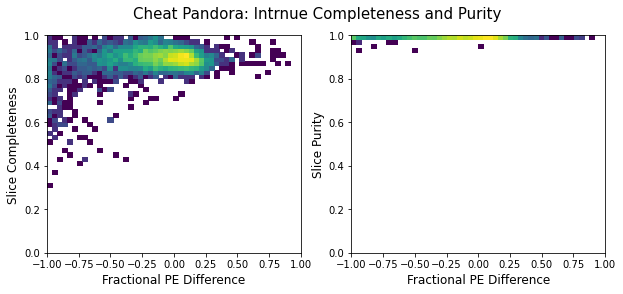

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(slc_opt0_nu_df.frac_pe
           ,slc_opt0_nu_df.slc_tmatch_eff
           ,bins=[np.linspace(-1,1,51),np.linspace(0,1,51)]
           ,norm=mpl.colors.LogNorm())
axes[0].set_xlabel("Fractional PE Difference",fontsize=12)
axes[0].set_ylabel("Slice Completeness",fontsize=12)

axes[1].hist2d(slc_opt0_nu_df.frac_pe
           ,slc_opt0_nu_df.slc_tmatch_pur
           ,bins=[np.linspace(-1,1,51),np.linspace(0,1,51)]
           ,norm=mpl.colors.LogNorm())
axes[1].set_xlabel("Fractional PE Difference",fontsize=12)
axes[1].set_ylabel("Slice Purity",fontsize=12)
plt.suptitle("Cheat Pandora: Intrnue Completeness and Purity",fontsize=15)
plt.show()

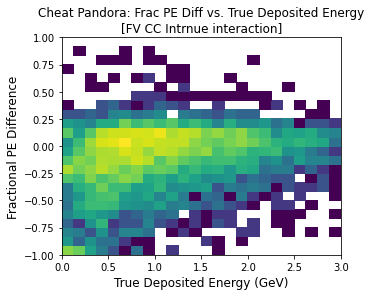

In [9]:
# look only at slices with high completeness 
fig = plt.figure(figsize=(5,4))
this_df = slc_opt0_nu_df.query("slc_tmatch_eff > 0.8")
# fig, axes = plt.subplots(1,2,figsize=(10,4))
plt.hist2d(this_df.total_prim_depE
           ,this_df.frac_pe
           ,bins=[np.linspace(0,3,25),np.linspace(-1,1,25)]
           ,norm=mpl.colors.LogNorm()
           )
plt.xlabel("True Deposited Energy (GeV)",fontsize=12)
plt.ylabel("Fractional PE Difference",fontsize=12)

plt.title("Cheat Pandora: Frac PE Diff vs. True Deposited Energy\n[FV CC Intrnue interaction]")
plt.show()

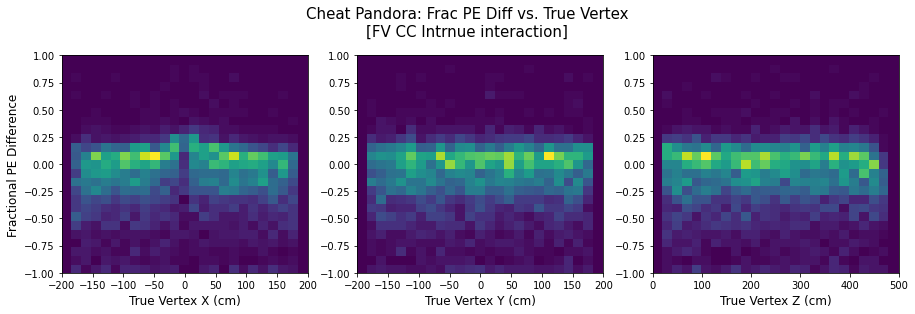

In [10]:
this_df = slc_opt0_nu_df.query("slc_tmatch_eff > 0.8")

fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist2d(this_df.position_x
           ,this_df.frac_pe
           ,bins=[np.linspace(-200,200,26),np.linspace(-1,1,26)]
        #    ,norm=mpl.colors.LogNorm()
           )
axes[1].hist2d(this_df.position_y
           ,this_df.frac_pe
           ,bins=[np.linspace(-200,200,26),np.linspace(-1,1,26)]
        #    ,norm=mpl.colors.LogNorm()
           )
axes[2].hist2d(this_df.position_z
           ,this_df.frac_pe
           ,bins=[np.linspace(0,500,26),np.linspace(-1,1,26)]
        #    ,norm=mpl.colors.LogNorm()
           )

axes[0].set_xlabel("True Vertex X (cm)", fontsize=12)
axes[1].set_xlabel("True Vertex Y (cm)", fontsize=12)
axes[2].set_xlabel("True Vertex Z (cm)", fontsize=12)

axes[0].set_ylabel("Fractional PE Difference", fontsize=12)
plt.suptitle("Cheat Pandora: Frac PE Diff vs. True Vertex\n[FV CC Intrnue interaction]", fontsize=15, y=1.05)


plt.show()

## Study on neutrino events with exiting primaries

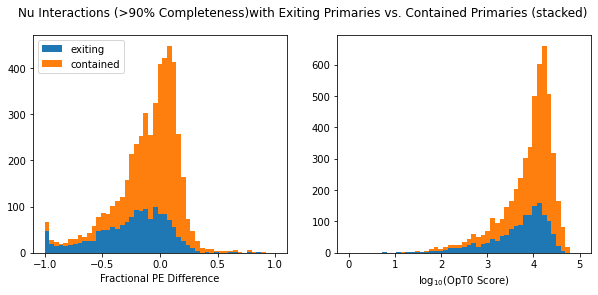

In [11]:
# this dataframe contains all slcs and all pfps (nu + cosmics )
slcpfp_nue_nu_df
# restrict to only neutrino slcs with high completeness 
slc_opt0_nu_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx != -999 & run>0 & (signal < 3) & slc_tmatch_eff > 0.80")
exit_slc_df = slc_opt0_nu_df.query("prim_cont == False")
cont_slc_df = slc_opt0_nu_df.query("prim_cont == True")
# plot what the frac pe distribution looks like in comparison between exiting and contained slcs
# compare the relative contributions of each population with a stacked histogram 
fig, axes = plt.subplots(1,2,figsize=(10,4))
bins = np.linspace(-1,1,50)
axes[0].hist([exit_slc_df.frac_pe,
          cont_slc_df.frac_pe],
          bins=bins,lw=2,label=["exiting","contained"],stacked=True)
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Fractional PE Difference")

axes[1].hist([np.log10(exit_slc_df.score),
              np.log10(cont_slc_df.score)],
              bins=np.linspace(0,5,50),lw=2,label=["exiting","contained"],stacked=True)
axes[1].set_xlabel(r"$\log_{10}$(OpT0 Score)")

plt.suptitle("Nu Interactions (>90% Completeness)with Exiting Primaries vs. Contained Primaries (stacked)")
plt.show()

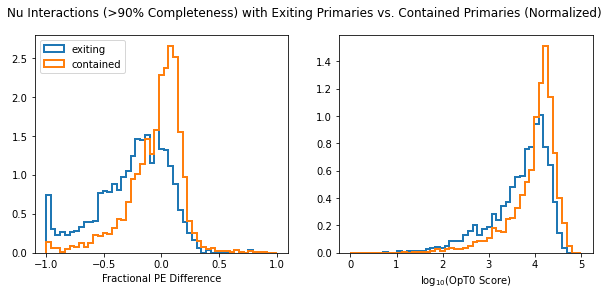

In [12]:
# compare the shapes of the distributions with a normalized histogram
fig, axes = plt.subplots(1,2,figsize=(10,4))
bins = np.linspace(-1,1,50)
axes[0].hist(exit_slc_df.frac_pe,bins=bins,density=True,lw=2,histtype="step",label="exiting")
axes[0].hist(cont_slc_df.frac_pe,bins=bins,density=True,lw=2,histtype="step",label="contained")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Fractional PE Difference")

axes[1].hist(np.log10(exit_slc_df.score),bins=np.linspace(0,5,50),density=True,lw=2,histtype="step",label="exiting")
axes[1].hist(np.log10(cont_slc_df.score),bins=np.linspace(0,5,50),density=True,lw=2,histtype="step",label="contained")
axes[1].set_xlabel(r"$\log_{10}$(OpT0 Score)")

plt.suptitle("Nu Interactions (>90% Completeness) with Exiting Primaries vs. Contained Primaries (Normalized)")
plt.show()
# the score distribution is not very different between neutrino events with exiting primaries vs neutrino events without.
# 

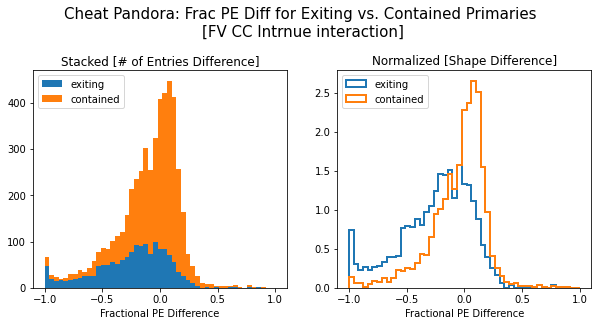

In [13]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
bins = np.linspace(-1,1,50)

axes[0].hist([exit_slc_df.frac_pe,
          cont_slc_df.frac_pe],
          bins=bins,lw=2,label=["exiting","contained"],stacked=True)
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Fractional PE Difference")
axes[0].set_title("Stacked [# of Entries Difference]")

axes[1].hist(exit_slc_df.frac_pe,bins=bins,density=True,lw=2,histtype="step",label="exiting")
axes[1].hist(cont_slc_df.frac_pe,bins=bins,density=True,lw=2,histtype="step",label="contained")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Fractional PE Difference")
axes[1].set_title("Normalized [Shape Difference]")

plt.suptitle("Cheat Pandora: Frac PE Diff for Exiting vs. Contained Primaries \n[FV CC Intrnue interaction]", fontsize=15, y=1.1)
plt.show()

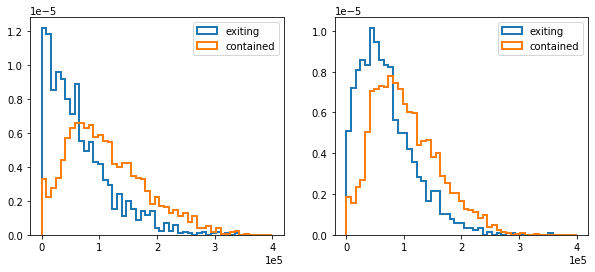

In [14]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
bins=np.linspace(0,4e5,50)
axes[0].hist(exit_slc_df.hypo_pe,bins=bins,density=True,lw=2,histtype="step",label="exiting")
axes[0].hist(cont_slc_df.hypo_pe,bins=bins,density=True,lw=2,histtype="step",label="contained")
axes[0].legend(loc="upper right")
axes[0].ticklabel_format(axis="x",style="sci",scilimits=(0,0))

axes[1].hist(exit_slc_df.flash_pe,bins=bins,density=True,lw=2,histtype="step",label="exiting")
axes[1].hist(cont_slc_df.flash_pe,bins=bins,density=True,lw=2,histtype="step",label="contained")
axes[1].legend(loc="upper right")
axes[1].ticklabel_format(axis="x",style="sci",scilimits=(0,0))
plt.show()


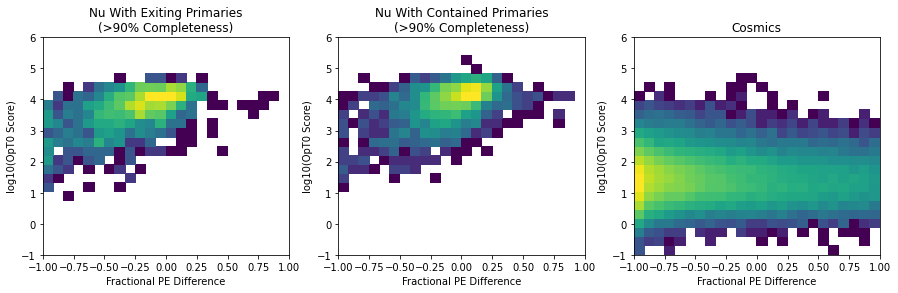

In [15]:
# get cosmics to compare 
cosm_slc_df = slcpfp_nue_nu_df.drop_duplicates(subset=slc_idx_set).query("slc_tmatch_idx == -999 & run>0" )

fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist2d(exit_slc_df.frac_pe,np.log10(exit_slc_df.score),bins=[np.linspace(-1,1,25),np.linspace(-1,6,25)],norm=mpl.colors.LogNorm())
axes[1].hist2d(cont_slc_df.frac_pe,np.log10(cont_slc_df.score),bins=[np.linspace(-1,1,25),np.linspace(-1,6,25)],norm=mpl.colors.LogNorm())
axes[2].hist2d(cosm_slc_df.frac_pe,np.log10(cosm_slc_df.score),bins=[np.linspace(-1,1,25),np.linspace(-1,6,25)],norm=mpl.colors.LogNorm())

axes[0].set_title("Nu With Exiting Primaries\n(>90% Completeness)")
axes[1].set_title("Nu With Contained Primaries\n(>90% Completeness)")
axes[2].set_title("Cosmics")
axes[0].set_ylabel("log10(OpT0 Score)")
axes[1].set_ylabel("log10(OpT0 Score)")
axes[2].set_ylabel("log10(OpT0 Score)")
axes[0].set_xlabel("Fractional PE Difference")
axes[1].set_xlabel("Fractional PE Difference")
axes[2].set_xlabel("Fractional PE Difference")
plt.show()

### Get pmt information

In [16]:
opdet_df = pd.DataFrame(np.load("/sbnd/data/users/lynnt/test_dump.npy",allow_pickle=True)).rename(columns={0:"opdet_x",1:"opdet_y",2:"opdet_z",3:"opdet_type",4:"opdet_tpc",5:"opdet"})
# plt.scatter(opdet_df[opdet_df.opdet_type<2].opdet_z, opdet_df[opdet_df.opdet_type<2].opdet_y)
# plt.show()

In [22]:
nue_opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/cheat_studies/intrnue_cheat_opt0_exitFalse.root:opt0finder/flash_match_tree").arrays(library="pd",entry_stop=1e4)


In [34]:
exit_slc_df[["entry","run","subrun","event","score","frac_pe","slc_self","nu_index",'tpc','total_prim_depE',"iscc"]].head(30).reset_index()

,index,entry,run,subrun,event,score,frac_pe,slc_self,nu_index,tpc,total_prim_depE,iscc
0,206,9,1.0,1.0,10.0,23609.427615,-0.206053,39,0,1.0,1.117204,1.0
1,245,10,1.0,1.0,11.0,7012.809450,-0.209195,36,0,1.0,2.094249,1.0
2,479,21,1.0,193.0,2.0,23896.617098,0.166107,14,0,1.0,1.202375,1.0
3,537,24,1.0,193.0,5.0,6510.114936,0.345208,17,0,0.0,0.565545,0.0
4,570,26,1.0,193.0,7.0,1121.146873,-0.332854,33,0,1.0,1.056402,1.0
5,661,31,1.0,193.0,12.0,3047.566023,-0.688036,24,0,0.0,1.866743,1.0
6,785,36,1.0,193.0,17.0,10543.991438,-0.739700,12,0,0.0,0.432955,0.0
7,890,42,1.0,192.0,3.0,13609.724445,-0.354581,34,0,1.0,2.019425,0.0
8,932,44,1.0,192.0,5.0,697.978432,-0.716384,10,0,1.0,0.021491,0.0
9,1011,49,1.0,192.0,10.0,1009.592914,-0.697090,32,0,0.0,1.483623,1.0


In [30]:
idx = 18
row = exit_slc_df[["entry","run","subrun","event","score","frac_pe","slc_self","nu_index",'tpc','total_prim_depE','slc_tmatch_eff']].iloc[idx]

run = row["run"]; sub = row["subrun"]; event = row["event"]
entry = row["entry"]
slcid = row["slc_self"]
tpc = row["tpc"]

print(pd.DataFrame(row))

                        1681
entry              84.000000
run                 1.000000
subrun            232.000000
event               5.000000
score            8498.205131
frac_pe            -0.477515
slc_self           22.000000
nu_index            0.000000
tpc                 0.000000
total_prim_depE     0.265229
slc_tmatch_eff      0.938413


In [32]:
evt_opt0_df = nue_opt0_df.query('run==@run & subrun==@sub & event==@event & pfpid==@slcid').reset_index().rename(columns={"subentry":"opdet"}).merge(opdet_df,on="opdet",how="left").query("opdet_type < 2")
evt_pfps_df = slcpfp_nue_nu_df.query('entry==@entry & slc_self==@slcid')
evt_prim_df = nue.flatten_df(nue_nuprim_df_0.copy()).query('entry==@entry')

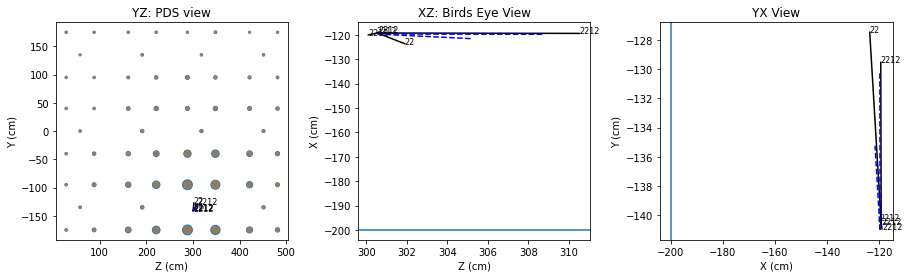

In [33]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
plt.subplots_adjust(wspace=0.3)
for prim in range(len(evt_prim_df.prim_start_z.to_numpy())):
    # don't plot the neutrino, neutrons, or pi0
    if abs(evt_prim_df.prim_pdg.to_numpy()[prim])==12: continue
    if abs(evt_prim_df.prim_pdg.to_numpy()[prim])==14: continue
    if abs(evt_prim_df.prim_pdg.to_numpy()[prim])==2112: continue
    if abs(evt_prim_df.prim_pdg.to_numpy()[prim])==111: continue
    start_z = evt_prim_df.prim_start_z.to_numpy()[prim]
    end_z = evt_prim_df.prim_end_z.to_numpy()[prim]
    start_x = evt_prim_df.prim_start_x.to_numpy()[prim]
    end_x = evt_prim_df.prim_end_x.to_numpy()[prim]
    start_y = evt_prim_df.prim_start_y.to_numpy()[prim]
    end_y = evt_prim_df.prim_end_y.to_numpy()[prim]
    axes[0].plot([start_z,end_z],[start_y,end_y],color="black")
    axes[1].plot([start_z,end_z],[start_x,end_x],color="black")
    axes[2].plot([start_x,end_x],[start_y,end_y],color="black")
    axes[0].annotate(evt_prim_df.prim_pdg.to_numpy()[prim],(end_z,end_y),fontsize=8)
    axes[1].annotate(evt_prim_df.prim_pdg.to_numpy()[prim],(end_z,end_x),fontsize=8)
    axes[2].annotate(evt_prim_df.prim_pdg.to_numpy()[prim],(end_x,end_y),fontsize=8)
    axes[0].set_xlabel("Z (cm)"); axes[1].set_xlabel("Z (cm)"); axes[2].set_xlabel("X (cm)")
    axes[0].set_ylabel("Y (cm)"); axes[1].set_ylabel("X (cm)"); axes[2].set_ylabel("Y (cm)")

for pfp in range(len(evt_pfps_df.pfp_shw_end_z.to_numpy())):
    start_z = evt_pfps_df.pfp_shw_start_z.to_numpy()[pfp] if evt_pfps_df.pfp_trackScore.to_numpy()[pfp] < 0.5 else evt_pfps_df.pfp_trk_start_z.to_numpy()[pfp]
    end_z = evt_pfps_df.pfp_shw_end_z.to_numpy()[pfp] if evt_pfps_df.pfp_trackScore.to_numpy()[pfp] < 0.5 else evt_pfps_df.pfp_trk_end_z.to_numpy()[pfp]
    start_x = evt_pfps_df.pfp_shw_start_x.to_numpy()[pfp] if evt_pfps_df.pfp_trackScore.to_numpy()[pfp] < 0.5 else evt_pfps_df.pfp_trk_start_x.to_numpy()[pfp]
    end_x = evt_pfps_df.pfp_shw_end_x.to_numpy()[pfp] if evt_pfps_df.pfp_trackScore.to_numpy()[pfp] < 0.5 else evt_pfps_df.pfp_trk_end_x.to_numpy()[pfp]
    start_y = evt_pfps_df.pfp_shw_start_y.to_numpy()[pfp] if evt_pfps_df.pfp_trackScore.to_numpy()[pfp] < 0.5 else evt_pfps_df.pfp_trk_start_y.to_numpy()[pfp]
    end_y = evt_pfps_df.pfp_shw_end_y.to_numpy()[pfp] if evt_pfps_df.pfp_trackScore.to_numpy()[pfp] < 0.5 else evt_pfps_df.pfp_trk_end_y.to_numpy()[pfp]
    axes[0].plot([start_z,end_z],[start_y,end_y],color="blue",linestyle="--")
    axes[1].plot([start_z,end_z],[start_x,end_x],color="blue",linestyle="--")
    axes[2].plot([start_x,end_x],[start_y,end_y],color="blue",linestyle="--")
    
this_opt0 = evt_opt0_df.query("opdet_tpc==@tpc")
axes[0].scatter(this_opt0.opdet_z,this_opt0.opdet_y,marker="o",s=this_opt0.flash_spec/25)
axes[0].scatter(this_opt0.opdet_z,this_opt0.opdet_y,marker="o",s=this_opt0.hypo_spec/25,alpha=0.5)
axes[0].set_title("YZ: PDS view")

xmin2, xmax1 = axes[1].get_xlim()
axes[1].hlines(-200 if tpc==0 else 200,xmin2,xmax1)
axes[1].set_xlim(xmin2,xmax1)
axes[1].set_title("XZ: Birds Eye View")
ymin2, ymax2 = axes[2].get_ylim()
axes[2].vlines(-200 if tpc==0 else 200,ymin2,ymax2)
axes[2].set_ylim(ymin2,ymax2)
axes[2].set_title("YX View")
plt.show()